# ERA5 Forecasting Visualizations

## Overview

This notebook contains the code for visualizing the trajectories forecasted by the sequential models based on an IVP ERA5 problem.

In [38]:
import sys
import os

# Get the current working directory
_here = os.path.abspath(os.path.dirname(''))

# Append the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(_here, '../../')))

import torch
import torch.nn as nn
import numpy as np
from src.models.TransformerSeq import TransformerDecoder
from src.models.NeuralODE import NeuralODE
from src.models.LSTMEncoderDecoder import LSTMDecoder
from src.data.cde_transforms import preprocess_for_transformer, fill_forward

# Set up matplotlib
import matplotlib.pyplot as plt

In [39]:
datapath = '../../data/processed/ERA5'

X = torch.load(f'{datapath}/X_test.pt')

In [40]:
def strip_y(y):
    # Strip time channel
    y = y[:, :, 1:]

    return y

def plot_trajectory(pred_y, batch_y):
    pred_y = pred_y.squeeze().detach().cpu().numpy()
    batch_y = batch_y.squeeze().detach().cpu().numpy()

    pred_temp = pred_y[:, 0]
    true_temp = batch_y[:, 0]
    pred_humidity = pred_y[:, 1]
    true_humidity = batch_y[:, 1]

    t = np.arange(len(pred_temp))

    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(6, 6))

    # Plot temperature
    axes[0].scatter(t, pred_temp, label='Predicted temperature', color='red')
    axes[0].scatter(t, true_temp, label='True temperature', color='blue')
    axes[0].plot(t, pred_temp, color='red', alpha=0.5)
    axes[0].plot(t, true_temp, color='blue', alpha=0.5)
    axes[0].set_xlabel('Bi-Monthly Time Step')
    axes[0].set_ylabel('Norm Value')
    axes[0].set_title('Temperature Trajectory')
    axes[0].legend()

    # Plot humidity
    axes[1].scatter(t, pred_humidity, label='Predicted humidity', color='green')
    axes[1].scatter(t, true_humidity, label='True humidity', color='orange')
    axes[1].plot(t, pred_humidity, color='green', alpha=0.5)
    axes[1].plot(t, true_humidity, color='orange', alpha=0.5)
    axes[1].set_xlabel('Bi-Monthly Time Step')
    axes[1].set_ylabel('Norm Value')
    axes[1].set_title('Humidity Trajectory')
    axes[1].legend()

    # Adjust layout
    plt.tight_layout()

    plt.show()


criterion = nn.functional.mse_loss

## Ground Truth

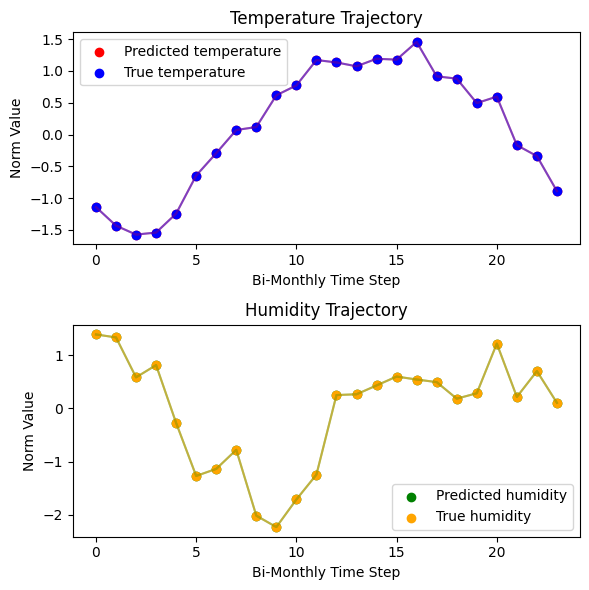

In [41]:
# Define hyperparameters
HP = {
    'log_dir': '/logs',
    'data_path': '../../data/processed/ERA5',
    'epochs': 150,
    'lr': 1e-3,
    'batch_size': 32,
    'input_channels': 3,
    'hidden_channels': 128,
    'output_channels': 2,
    'n_layers': 2
}

# Set up test dataloader
test_dataset = torch.utils.data.TensorDataset(X)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=HP['batch_size'])

batch_x = next(iter(test_dataloader))[0]

# Get mask of batch_y (where all values are zero)
batch_y = strip_y(batch_x)

plot_trajectory(batch_y[0], batch_y[0])

## Neural ODE Model

The model has 17,026 trainable parameters
Mean Squared Error: 0.21429681777954102


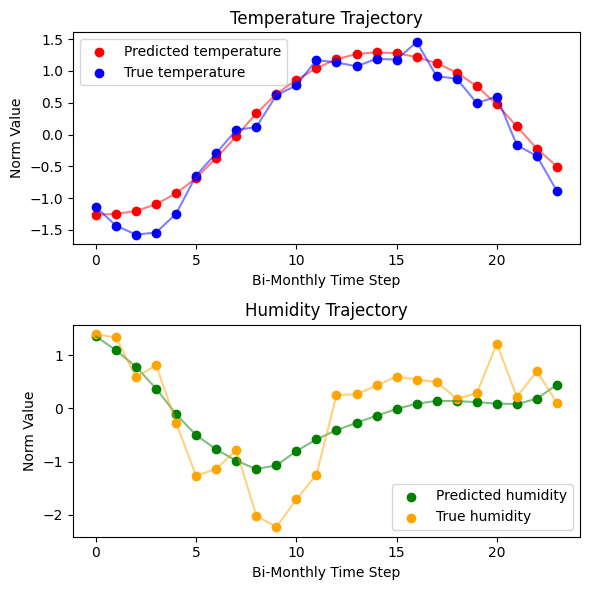

In [42]:
# Define hyperparameters
HP = {
    'log_dir': '/logs',
    'data_path': '../../data/processed/ERA5',
    'epochs': 150,
    'lr': 1e-3,
    'batch_size': 2,
    'input_channels': 3,
    'hidden_channels': 64,
    'output_channels': 2,
    'hidden_layers': 3,
    'method': 'rk4',
    'step_size': 1
}

# Set up test dataloader
test_dataset = torch.utils.data.TensorDataset(X)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=HP['batch_size'])

# Define model
model = NeuralODE(HP['input_channels'], HP['hidden_channels'], HP['output_channels'])

# Load model
model.load_state_dict(torch.load('logs/node_model.pth'))

# Print the number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

# Set model to evaluation mode
model.eval()

batch_x = next(iter(test_dataloader))[0]

# Get predictions
pred_y = model(batch_x)

# Get mask of batch_y (where all values are zero)
batch_y = strip_y(batch_x)

mse = criterion(pred_y, batch_y)
print(f'Mean Squared Error: {mse}')

plot_trajectory(pred_y[0], batch_y[0])

## Transformer Decoder Model

The model has 425,538 trainable parameters
Mean Squared Error: 0.21719615161418915


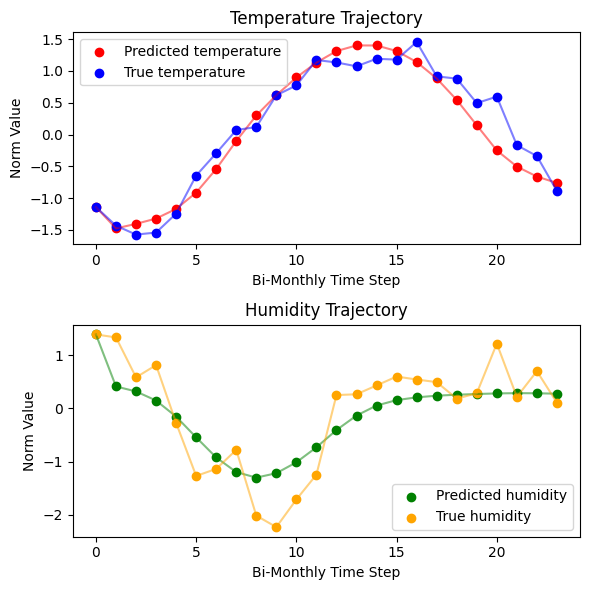

In [43]:
# Define hyperparameters
HP = {
    'log_dir': '/logs',
    'data_path': '../../data/processed/ERA5',
    'epochs': 150,
    'lr': 1e-3,
    'batch_size': 32,
    'input_channels': 2,
    'hidden_channels': 32,
    'output_channels': 2,
    'hidden_layers': 3,
    'n_heads': 4,
    'n_layers': 3,
    'dropout': 0.1
}

# Set up test dataloader
test_dataset = torch.utils.data.TensorDataset(X)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=HP['batch_size'])

# Define model
model = TransformerDecoder(HP['input_channels'], HP['hidden_channels'], HP['n_heads'], HP['n_layers'], HP['dropout'], HP['output_channels'])

# Load model
model.load_state_dict(torch.load('logs/transformer_model.pth'))

# Print the number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

# Set model to evaluation mode
model.eval()

batch_x = next(iter(test_dataloader))[0]

# Strip time channel
batch_y = strip_y(batch_x)
y0 = batch_y[:, 0, :].unsqueeze(1)

pred_y = model.autoregressive_predict(y0, max_len=23)

mse = criterion(pred_y, batch_y)
print(f'Mean Squared Error: {mse}')

plot_trajectory(pred_y[0], batch_y[0])

## LSTM Decoder Model

The model has 199,938 trainable parameters
Mean Squared Error: 0.18492275476455688


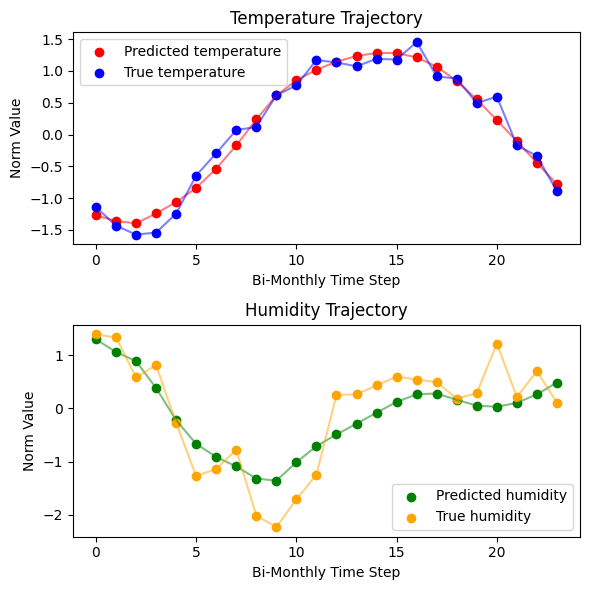

In [44]:
# Define hyperparameters
HP = {
    'log_dir': '/logs',
    'data_path': '../../data/processed/ERA5',
    'epochs': 150,
    'lr': 1e-3,
    'batch_size': 32,
    'input_channels': 2,
    'hidden_channels': 128,
    'output_channels': 2,
    'n_layers': 2
}

# Set up test dataloader
test_dataset = torch.utils.data.TensorDataset(X)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=HP['batch_size'])

# Define model
model = LSTMDecoder(HP['input_channels'], HP['hidden_channels'], HP['n_layers'], HP['output_channels'])

# Load model
model.load_state_dict(torch.load('logs/lstm_model.pth'))

# Print the number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

# Set model to evaluation mode
model.eval()

batch_x = next(iter(test_dataloader))[0]

batch_y = strip_y(batch_x)
y0 = batch_y[:, 0, :].unsqueeze(1)

# Get predictions
pred_y = model.autoregressive_predict(y0, batch_y.size(1))

mse_loss = criterion(pred_y, batch_y)
print(f'Mean Squared Error: {mse_loss}')

plot_trajectory(pred_y[0], batch_y[0])